### This code can clip and resample the input raster files.
It provides follwing two main operations.
- Clip and resample an input raster file to match a reference raster.
- Resample an input raster file to an arbitrary resolution and a region.

Example of situations that this code might be helpful:
- We have many files that must have a same dimention and crs of a reference raster. For example, a combined use of MODIS products that have different spatial resolutions.
- We want to reduce the region of interest to a smaller scale. 
- We want to change the resolution to a different scale. 

**This code will work if the following conditions are met.**
- The target folder or directory has sub folders or directories.
- The target images are in the sub folders or directories, not in the target folder itself.

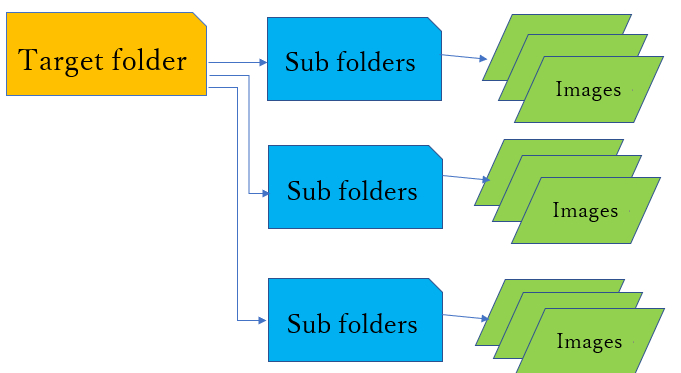

In [7]:
import rasterio 
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import json
import pycrs
import numpy as np
from rasterio.enums import Resampling
import os, glob, shutil
from tqdm import tqdm



class ClipResampleRaster:
    
    def __init__(self,pathToTargetFolder,pathToRefImage=None):
        self.pathToTargetFolder=pathToTargetFolder 
        if pathToRefImage==None:
            pass
        else:
            self.pathToRefImage=pathToRefImage
    
    def boundaryBox_ref(self):
        ref_image=rasterio.open(self.pathToRefImage)
        bounds=ref_image.bounds
        bbox = box(bounds[0], bounds[1], bounds[2], bounds[3])
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs=ref_image.crs)
        coords=[json.loads(geo.to_json())['features'][0]['geometry']]
        return coords
    
    def outputRasterMeta_ref(self):
        ref_image=rasterio.open(self.pathToRefImage)
        self.height=ref_image.meta["height"]
        self.width=ref_image.meta["width"]
        self.count=ref_image.meta["count"]
        self.crs=ref_image.meta["crs"]
        self.transform=ref_image.meta["transform"]
        
    def boundaryBox(self,boxCoordinates=None):
        pathToIndividualFolder=os.listdir(self.pathToTargetFolder)[0]
        fileName=os.listdir(self.pathToTargetFolder+f"\{pathToIndividualFolder}")[0]
        path=self.pathToTargetFolder+\
        f"\{pathToIndividualFolder}"+\
        f"\{fileName}"
        src_image=rasterio.open(path) 
        
        if boxCoordinates==None:
            boxCoordinates=list(src_image.bounds)
            bbox=box(boxCoordinates[0],boxCoordinates[1],boxCoordinates[2],boxCoordinates[3])
        else:
            bbox=box(boxCoordinates[0],boxCoordinates[1],boxCoordinates[2],boxCoordinates[3])
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=src_image.crs)
        coords=[json.loads(geo.to_json())['features'][0]['geometry']]
        self.mapCenter=((boxCoordinates[0]+boxCoordinates[2])/2,(boxCoordinates[1]+boxCoordinates[3])/2)
        
        out_img, out_transform = rasterio.mask.mask(src_image, coords, crop=True)
        self.width=out_img.shape[2]
        self.height=out_img.shape[1]
        self.transform=out_transform
        return coords
    
    def outputRasterMeta(self,resolutionByMeter,resolutionByDegree=None):
        pathToIndividualFolder=os.listdir(self.pathToTargetFolder)[0]
        fileName=os.listdir(self.pathToTargetFolder+f"\{pathToIndividualFolder}")[0]
        path=self.pathToTargetFolder+\
        f"\{pathToIndividualFolder}"+\
        f"\{fileName}"
        src_image=rasterio.open(path)
        if (src_image.meta["crs"]==from_epsg(4326))==True:
            d=resolutionByMeter/1000
            r=6371
            lat=np.radians(self.mapCenter[1])
            resolution=abs(np.degrees(2*np.arcsin(np.sin(d/(2*r)))))
        elif (resolutionByDegree!=None)==True:
            resolution=resolutionByDegree
        else:
            resolution=resolutionByMeter
        
        src_affine=src_image.meta["transform"]
        src_width=src_image.meta["width"]
        src_height=src_image.meta["height"]
        target_transform,target_width,target_height=\
        rasterio.warp.aligned_target(self.transform,self.width,self.height,resolution)
        
        self.height=target_height
        self.width=target_width
        self.count=src_image.meta["count"]
        self.crs=src_image.meta["crs"]
        self.transform=target_transform
        
    def getTargetFiles(self):
        targetFolderNames=os.listdir(self.pathToTargetFolder)
        targetFiles={}
        for name in targetFolderNames:
            targetFiles[name]=os.listdir(self.pathToTargetFolder+f"\{name}")
        self.targetFiles=targetFiles
    
    def resampleRaster(self,path,fileName,resamplingMethod):
        if resamplingMethod=="nearest":
            resamplingMethod_func=Resampling.nearest
        elif resamplingMethod=="bilinear":
            resamplingMethod_func=Resampling.bilinear
        else:
            print("Please specify the resampling method either nearest or bilinear.")
            
        name=fileName.replace(".tif","")
        with rasterio.open(path+f"\{name}_clipped.tif") as dataset:
            dataset=dataset.read(out_shape=(self.height,self.width),resampling=resamplingMethod_func)
        return dataset
    
    def writeClippedRaster(self,path,fileName):
        data=rasterio.open(path+f"\{fileName}")
        out_img, out_transform = rasterio.mask.mask(data, coords, crop=True)
        name=fileName.replace(".tif","")
        dtype=out_img.dtype
        with rasterio.open(path+f"/{name}_clipped.tif",
                           'w',
                           driver='GTiff',
                           width=out_img.shape[2],
                           height=out_img.shape[1],
                           count=data.count,
                           crs=data.crs,
                           transform=out_transform,
                           dtype=dtype) as output:
            for i in range(data.count):
                output.write(out_img[i],i+1)
            output.close()
        data.close()
    
    def writeResampledRaster(self,path,fileName,raster):
        dtype=raster.dtype
        name=fileName.replace(".tif","")
        with rasterio.open(path+f"\{name}_resampled.tif",
                           'w',
                           driver='GTiff',
                           width=self.width,
                           height=self.height,
                           count=self.count,
                           crs=self.crs,
                           transform=self.transform,
                           dtype=dtype) as output:
            for i in range(self.count):
                output.write(raster[i],i+1)
            output.close()
    
    def writeOutputRaster(self,resamplingMethod,suffixOfSavedFileFolder):
        targetFiles=self.targetFiles
        writeClippedRaster=self. writeClippedRaster
        resampleRaster=self.resampleRaster
        writeResampledRaster=self.writeResampledRaster
        for folder in tqdm(targetFiles.keys()):
            path=self.pathToTargetFolder+f"\{folder}"
            path_to_savedFileFolder=self.pathToTargetFolder+f"\{folder}_{suffixOfSavedFileFolder}"
            os.mkdir(path_to_savedFileFolder)
            for fileName in targetFiles[f"{folder}"]:
                writeClippedRaster(path,fileName)
                dataset=resampleRaster(path,fileName,resamplingMethod)
                writeResampledRaster(path_to_savedFileFolder,fileName,dataset)
    
    def cleanUp(self):
        targetFiles=self.targetFiles
        for folder in tqdm(targetFiles.keys()):
            path=self.pathToTargetFolder+f"\{folder}"
            shutil.rmtree(path)
        print("The clean up process is completed!")   

**ClipResampleRaster.boudaryBox_ref()**
- Calculates the coordinates of the reference image.

**ClipResampleRaster.outputRasterMeta_ref()**
- Calculates the necessary metadata to match the target rasters to the reference image.

**ClipResampleRaster.boudaryBox(boxCoordinates=None)**
- Calculates the boundary coordinates of the clipped rasters. If the image is in UTM, it automatically converts lat/long inputs to the UTM coordinates.
- If no ROI coordinates are given, the original raster boundary coordinates will be used.

**ClipResampleRaster.outputRasterMeta(resolutionByMeter,resolutionByDegree=None)**
- Calculates the necessary resolution information of the output raster. If the target rasters are in lat/long coordinates, the target resolution value given by a meter unit is converted into an approximate degree resolution by using an inverst of the haversine formula.
- It is also possible to give a resolution by a degree unit.

**ClipResampleRaster.getTargetFiles()**
- Get a list of file names of target rasters.

**ClipResampleRaster.writeOutputRaster(resamplingMethod,suffixOfSavedFileFolder)**
- The available resampling methods are the nearest neighbor or the bilinear.
- You need to give the suffix for the folders that store the resampled and clipped rasters.

**ClipResampleRaster.cleanUp()**
- Delete all the unnecessary files. Only the resampled and clipped rasters are left.

### First example: Clip and resample rasters to match their shape and resolution to a reference image.

In [8]:
targetFolderPath="C:\\Users\shoki\Desktop\TargetFolder" #A path to the folder which contains rasters we want to process
referenceImagePath="C:\\Users\shoki\Downloads\MCD12Q1.A2001001.IGBP.Buryat.geotiff.tif" #A path to the reference image

database=ClipResampleRaster(targetFolderPath,referenceImagePath) 
coords=database.boundaryBox_ref() #Get the coordinates of the bound of the reference image
database.getTargetFiles() #Get a list of rasters we want to process
database.outputRasterMeta_ref() #Calculate necessary the input metadata
database.writeOutputRaster("nearest","outputFileFolder") #Write processed rasters

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:20<00:00, 146.94s/it]


### Second example: Resample rasters to an arbitrary resolution.

In [10]:
targetFolderPath="C:\\Users\shoki\Desktop\TargetFolder"
database=ClipResampleRaster(targetFolderPath)
coords=database.boundaryBox() 
database.getTargetFiles()
database.outputRasterMeta(2000) #Specify the resolution to 2000 m.
database.writeOutputRaster("nearest","outputFileFolder")

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:29<00:00, 29.82s/it]


### Third example: Resample rasters to an arbitrary resolution. We also clip rasters to a region of interest (ROI).

In [12]:
bounds=[100,52,105,55] #The coordinates of ROI in a rectangular shape. ROI=[xmin, ymin, xmax, ymax]

targetFolderPath="C:\\Users\shoki\Desktop\TargetFolder"
database=ClipResampleRaster(targetFolderPath)
coords=database.boundaryBox(bounds) #Get the coordinates for the output rasters.
database.getTargetFiles()
database.outputRasterMeta(2000)
database.writeOutputRaster("nearest","outputFileFolder")

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:30<00:00, 10.18s/it]


In [13]:
#Delete the uncessesary files
database.cleanUp()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.22it/s]

The clean up process is completed!
